In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import igraph as ig
import random
from matplotlib.lines import Line2D

mpl.rcParams['figure.dpi'] = 300
L = 15
sequences_int = range(2**L)

def reachable(s, L):
    return [(s | 2**ii) for ii in range(L) if (s | 2**ii) > s]
mutation_names = ['G339D','S371L','S373P','S375F','K417N','N440K','G446S','S477N','T478K','E484A','Q493R','G496S','Q498R','N501Y','Y505H']


In [2]:
df = pd.read_csv(f"../Titeseq/results/Kds/cleaned_Kds_RBD_ACE2.tsv",
                 dtype={"geno":"str"}, sep="\t")


reps = set([a.split("_")[-1] 
            for a in df.keys() 
            if a.startswith("mean_log10PE")])
concs = set([int(a.split("_")[1][7:])
            for a in df.keys() 
            if a.startswith("mean_log10PE")])            
for aa in reps:
    for ii in concs:
        df = df.rename({f"mean_log10PE{ii}_{aa}": f"mean_log10PE{ii}_{aa}_ACE2",
                   f"std_log10PE{ii}_{aa}":f"std_log10PE{ii}_{aa}_ACE2"}, axis=1) 

for ab in ['CB6', 'CoV555', 'REGN10987', 'S309']:
    dft = pd.read_csv(f"../Titeseq/results/Kds/cleaned_Kds_RBD_{ab}_proper.tsv",
                 dtype={"geno":"str"}, sep=",").set_index("geno")
    dft.log10Kd = dft.log10Kd.apply(lambda x: 6 if pd.isna(x) else x)
    df[f"log10Kd_{ab}"] = df.geno.map(dft.log10Kd)
    df[f"err_log10Kd_{ab}"] = df.geno.map(dft.err_log10Kd)
    
    repscon = set([(a.split("_")[-1], int(a.split("_")[1][7:]))
                for a in dft.keys() 
                if a.startswith("mean_log10PE")])
    for aa, ii in repscon:
            df[f"mean_log10PE{ii}_{aa}_{ab}"] = df.geno.map(dft[f"mean_log10PE{ii}_{aa}"])
            df[f"std_log10PE{ii}_{aa}_{ab}"] = df.geno.map(dft[f"std_log10PE{ii}_{aa}"])




df["variant_int"] = df.geno.apply(lambda x: int(x, 2))

df = df.set_index("variant_int").reindex(range(0, 2**L)).reset_index()
sequences_int = range(0,2**L)
for ii in range(L):
    df[f"mutation_{ii+1}"] = df.geno.str[ii] == '1'
    
df["expression_norm_b"] = df['Mean fluorescence expression_b']/df['Mean fluorescence expression_b'].mean()
df["expression_norm_a"] = df['Mean fluorescence expression_a']/df['Mean fluorescence expression_a'].mean()
df["expression_norm"] = 1/2*(df["expression_norm_a"] + df["expression_norm_b"])

/tmp/ipykernel_276478/956960921.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"mean_log10PE{ii}_{aa}_{ab}"] = df.geno.map(dft[f"mean_log10PE{ii}_{aa}"])
/tmp/ipykernel_276478/956960921.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"std_log10PE{ii}_{aa}_{ab}"] = df.geno.map(dft[f"std_log10PE{ii}_{aa}"])
/tmp/ipykernel_276478/956960921.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all c

/tmp/ipykernel_276478/956960921.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"std_log10PE{ii}_{aa}_{ab}"] = df.geno.map(dft[f"std_log10PE{ii}_{aa}"])
/tmp/ipykernel_276478/956960921.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"log10Kd_{ab}"] = df.geno.map(dft.log10Kd)
/tmp/ipykernel_276478/956960921.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(a

/tmp/ipykernel_276478/956960921.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"mean_log10PE{ii}_{aa}_{ab}"] = df.geno.map(dft[f"mean_log10PE{ii}_{aa}"])
/tmp/ipykernel_276478/956960921.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"std_log10PE{ii}_{aa}_{ab}"] = df.geno.map(dft[f"std_log10PE{ii}_{aa}"])
/tmp/ipykernel_276478/956960921.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all c

In [3]:
import re
for ag in ['CB6', 'CoV555', 'REGN10987', 'S309']:
    df[f"max_fluo_{ag}"] = df[[a for a in df.keys() if re.match(f"mean_log10PE._._{ag}", a) is not None]].max(axis=1)
    df[f"min_fluo_{ag}"] = df[[a for a in df.keys() if re.match(f"mean_log10PE._._{ag}", a) is not None]].min(axis=1)
    df[f"difference_{ag}"] = df[f"max_fluo_{ag}"] - df[f"min_fluo_{ag}"]
    df[f"is_non_binder_{ag}"] = df[f"difference_{ag}"] < 1

In [4]:
#### FOR TESTING LAYOUT ####
# shorter dataframe for easy initial testing
L = 10
df["variant_int"] = df.geno.apply(lambda x: int(x, 2))
df = df[df.variant_int < 2**L].copy()
df["geno"] = df["geno"].apply(lambda x: x[:8])
df = df.set_index("variant_int").reindex(range(0, 2**L)).reset_index()
sequences_int = range(0,2**L)
for ii in range(L):
    df[f"mutation_{ii+1}"] = df.geno.str[ii] == '1'
############################


In [4]:
# read data into graph


fitnesses = {}
#fitnesses["ACE2"] = (df.set_index("variant_int")["log10Kd"]).to_dict()
for ab in ['CB6', 'CoV555', 'REGN10987', 'S309']:
    fitnesses[ab] = (df.set_index("variant_int")[f"log10Kd_{ab}"]).to_dict()

g = ig.Graph()
vertices = [s for s in sequences_int]# if ~np.isnan(fitnesses["ACE2"][s])]
g.add_vertices([str(s) for s in vertices])
g.add_edges([(str(s),str(t)) for s in vertices for t in reachable(s, L) if t in vertices])


#### weight choices ####
# high weight means very close nodes on the graph.
weight_strength = 10
min_difference = 1e-6
g.es["weight"] = [weight_strength/(min_difference 
                                   + np.nanmean([
                                       np.abs(fitnesses[solu][t] - fitnesses[solu][s])
                                       for solu in fitnesses
                                         ])
                                   ) # weight
                            for s in vertices
                            for t in reachable(s, L) if t in vertices]
########################

g.vs["endpoints"] = [(s == 0 or s == len(sequences_int)-1) for s in sequences_int]



In [5]:
# draw the layout

# generate seed
random.seed(42) 
seed = np.empty((len(vertices),2))
for i in range(len(vertices)):
    xcoord = random.uniform(-100,100)
    ycoord = random.uniform(-100,100)
    seed[i,:] = [xcoord,ycoord]
    
# create layout
layout = g.layout_drl(weights='weight',seed=seed)

# update df
coord =  np.array(layout.coords)
#print(coord)
xcoord = {vertices[i]:-1.0*coord[i, 1] for i in range(len(vertices))}
ycoord = {vertices[i]:coord[i, 0] for i in range(len(vertices))}
df["fdl_x"] = df.variant_int.map(xcoord)
df["fdl_y"] = df.variant_int.map(ycoord)



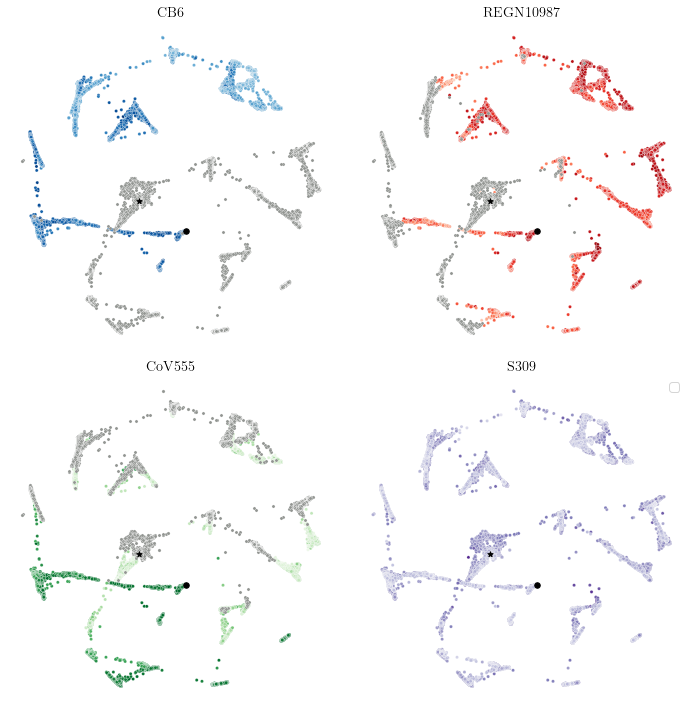

In [8]:
from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Arial']})
plt.rcParams['font.size'] = 12
rc('text', usetex=True)
fig, axes = plt.subplots(2, 2, figsize=(10,10))

for ax, ab, pal in zip(axes.flatten(),
                  ["CB6", "REGN10987", "CoV555", "S309"],
                 ["Blues", "Reds", "Greens", "Purples"]):
    sc = sns.scatterplot(data=df[df[f"log10Kd_{ab}"] > 6], x="fdl_x", y="fdl_y", 
               s=10, hue=f"log10Kd_{ab}", palette=sns.color_palette(pal, as_cmap=True), ax=ax)
    sc = sns.scatterplot(data=df[df[f"log10Kd_{ab}"] == 6], x="fdl_x", y="fdl_y", 
               s=10, color="xkcd:grey", ax=ax)
    ax.scatter(x=df[df.geno == "0"*L].fdl_x, y=df[df.geno == "0"*L].fdl_y,
               s=30, c='black', alpha=1, marker="o")
    ax.scatter(x=df[df.geno == "1"*L].fdl_x, y=df[df.geno == "1"*L].fdl_y,
               s=30, c="black", alpha=1, marker="*")
    ax.set_aspect('equal')
    ax.set_axis_off()
    ax.set_title(ab)
    ax.get_legend().remove()

plt.tight_layout()

plt.legend(title="LY-CoV016 / REGN10987 / LY-CoV555 ")
plt.legend([])
#plt.show()
plt.savefig("fdl_omicron_antibodies.png", dpi=600)

In [6]:
df["binding_status"] = df.apply(lambda r: (r["is_non_binder_CB6"], r["is_non_binder_REGN10987"], r["is_non_binder_CoV555"]), axis=1)
df["binding_status"] = df["binding_status"].map({(True, True, True): "- / - / -"  , 
                                                 (True, True, False): "- / - / +",
                          (True, False, True): "- / + / -"  , (True, False , False): "- / + / +",
                          (False, False, True): "+ / + / -", (False,False , False): "+ / + / +",
                          (False, True, True): "+ / - / -" , (False, True, False): "+ / - / +",
                         })

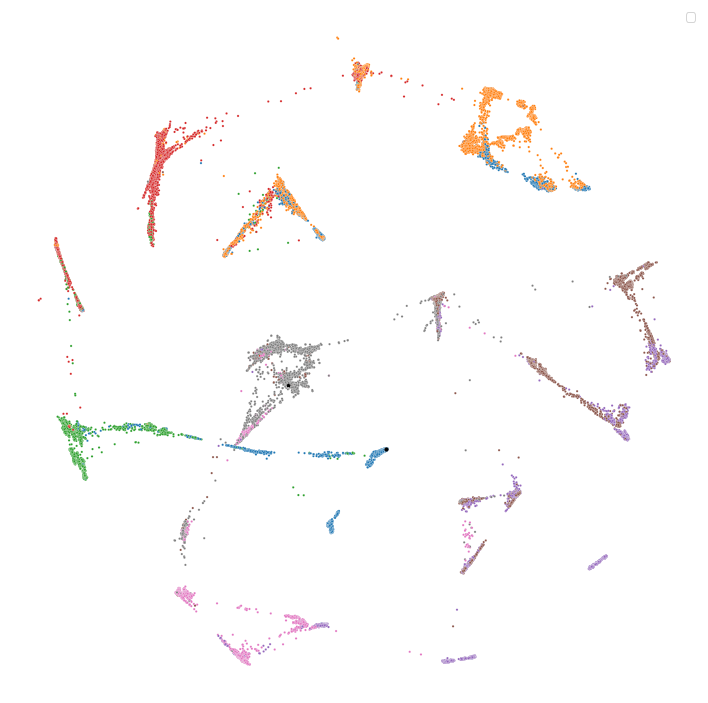

<Figure size 432x288 with 0 Axes>

In [11]:
from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Arial']})
plt.rcParams['font.size'] = 12
rc('text', usetex=True)

fig, ax = plt.subplots(figsize=(10,10))
sc = sns.scatterplot(data=df, x="fdl_x", y="fdl_y", 
           s=5, hue="binding_status")

ax.scatter(x=df[df.geno == "0"*L].fdl_x, y=df[df.geno == "0"*L].fdl_y,
           s=10, c='black', alpha=1, marker="o")
ax.scatter(x=df[df.geno == "1"*L].fdl_x, y=df[df.geno == "1"*L].fdl_y,
           s=10, c="black", alpha=1, marker="*")
ax.set_aspect('equal')
ax.set_axis_off()
plt.tight_layout()

plt.legend(title="LY-CoV016 / REGN10987 / LY-CoV555 ")
plt.legend([])
plt.show()
plt.savefig("fdl-abs.pdf")
df[["is_non_binder_CB6","is_non_binder_REGN10987", "is_non_binder_CoV555", "fdl_x", "fdl_y"]].to_csv("fdl_antibodies.csv")

In [12]:
pd.read_csv("fdl_antibodies.csv")

,Unnamed: 0,is_non_binder_CB6,is_non_binder_REGN10987,is_non_binder_CoV555,fdl_x,fdl_y
0,0,False,False,False,2.561295,-91.837112
1,1,False,False,False,2.102437,-91.779549
2,2,False,False,False,1.857612,-92.061905
3,3,False,False,False,1.744364,-92.312920
4,4,False,False,False,3.472127,-91.543221
...,...,...,...,...,...,...
32763,32763,True,True,True,-69.779266,-45.082291
32764,32764,True,True,True,-68.965797,-45.445339
32765,32765,True,True,True,-67.338524,-45.447712
32766,32766,True,True,True,-69.840714,-45.322201


In [56]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X = pca.fit_transform(df[["log10Kd_CB6", "log10Kd_REGN10987", "log10Kd_CoV555"]])


In [12]:
## Prepare the csv for the data browser
df["variant"] = df.geno
df["ACE2_log10Kd"] = -df.log10Kd
df["ACE2_stelog10Kd"] = df.err_log10Kd
# not actually a Kd but the browser is dumb
df["Expression_log10Kd"] = df.expression_norm
df["Expression_stelog10Kd"] = np.sqrt((df.expression_norm_a - df.expression_norm)**2 + 
                                      (df.expression_norm_b - df.expression_norm)**2)/np.sqrt(2)


for ab in ['CB6', 'CoV555', 'REGN10987', 'S309']:
    df[f"{ab}_log10Kd"] = -df[f"log10Kd_{ab}"]
    df[f"{ab}_stelog10Kd"] = df[f"err_log10Kd_{ab}"]

solutes = ['ACE2', 'CB6', 'CoV555', 'REGN10987', 'S309']
for ab in solutes:
    for ii in range(L):
        Kds = df.set_index("geno")[f"{ab}_log10Kd"].to_dict()
        df[f"{ab}_{ii}_deltaKd"] = df.geno.apply(lambda x: (x,x[:ii]+'1'+x[ii+1:]) if x[ii] == '0' else "null")
        df[f"{ab}_{ii}_deltaKd"] = df[f"{ab}_{ii}_deltaKd"].apply(lambda x: Kds[x[1]] - Kds[x[0]]
                                                                  if x != "null" else "null")

df[["variant"] +
    [f"{ab}_log10Kd" for ab in solutes] + [f"{ab}_stelog10Kd" for ab in solutes]
    + ["Expression_log10Kd", "Expression_stelog10Kd",
    "fdl_x", "fdl_y"] + 
   [f"{ab}_{ii}_deltaKd" for ii in range(L) for ab in solutes]
  ].to_csv("../Browser/data/omicron_justACE2.csv")


## Prepare the mean bin pyarrow for the data browser
for ab in solutes:
    dfmb = df.copy()
    repscon = set([(a.split("_")[-2], int(a.split("_")[1][7:]))
                for a in dfmb.keys() 
                if a.startswith("mean_log10PE") and a.endswith(ab)])
    cols = ["variant", f"{ab}_log10Kd"]
    for aa, ii in repscon:
        dfmb[f"c{ii}_{aa}"] = dfmb[f"mean_log10PE{ii}_{aa}_{ab}"]
        dfmb[f"e{ii}_{aa}"] = dfmb[f"std_log10PE{ii}_{aa}_{ab}"]
        cols += [f"c{ii}_{aa}", f"e{ii}_{aa}"]
    dfmb.dropna(subset=[f"{ab}_log10Kd"]).reset_index()[cols].to_feather(
        f"../Browser/data/{ab}_justACE2.arrow", compression="uncompressed")